<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   traffic  393 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


<AxesSubplot:>

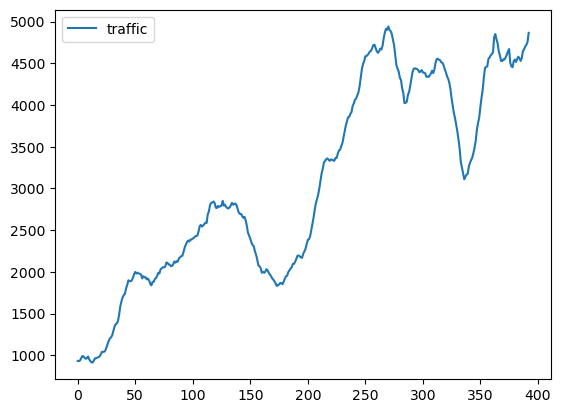

In [1]:
# aim is to build a model that predicts the next 30 obs of var traffic
import pandas as pd
df = pd.read_csv('website_data.csv')
df.info()

df.plot()

<AxesSubplot:>

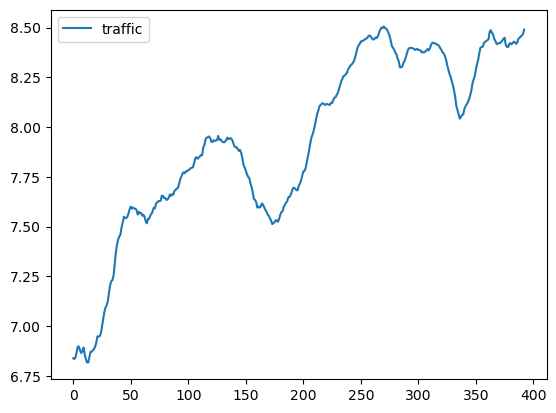

In [2]:
# large amount of variance in data. transform the data using log to stablise it
import numpy as np
df = np.log(df)

df.plot()

In [3]:
# split data into training and testing
msk = (df.index < len(df)-30)
df_train = df[msk].copy()
df_test = df[~msk].copy()

C:\Users\Elliot\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


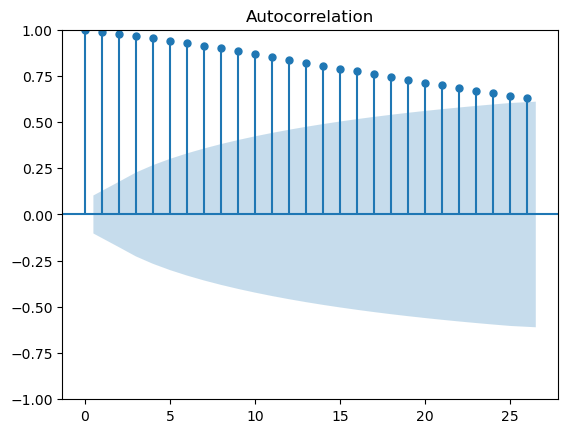

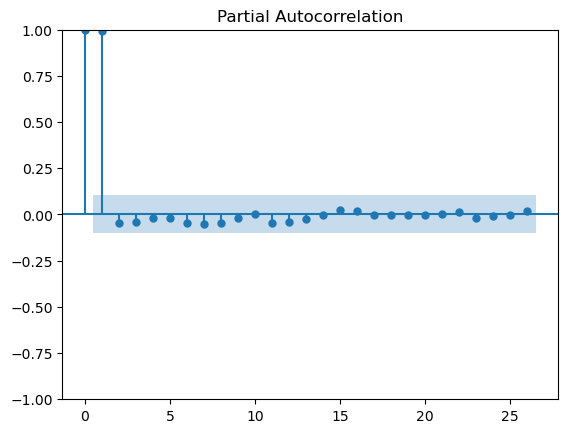

In [4]:
# check for stationarity
# ACF plot and PACF plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

In [5]:
# visually, evidence of non-stationarity, i.e. random walk given decay of lagged values (?)
# can confirm this visual tell using statistical tests
# adf, augmented dicky-fuller test, checks null for unit root. i.e. stationarity

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value: {adf_test[1]}')

p-value: 0.2412611608288296


<AxesSubplot:>

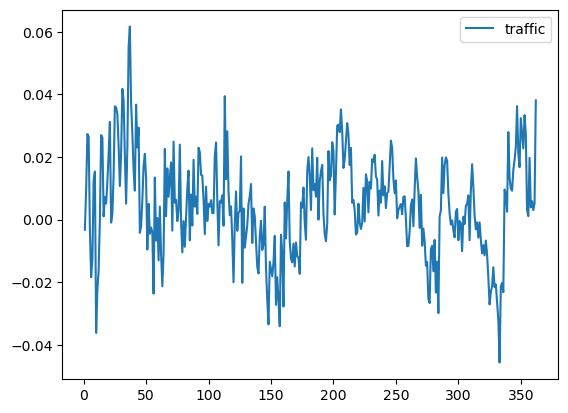

In [6]:
# with a p-value of x > 0.05, we fail to reject null for unit root, confirming statistically non-stationarity
# now we transform the data to stationariy

df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

C:\Users\Elliot\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


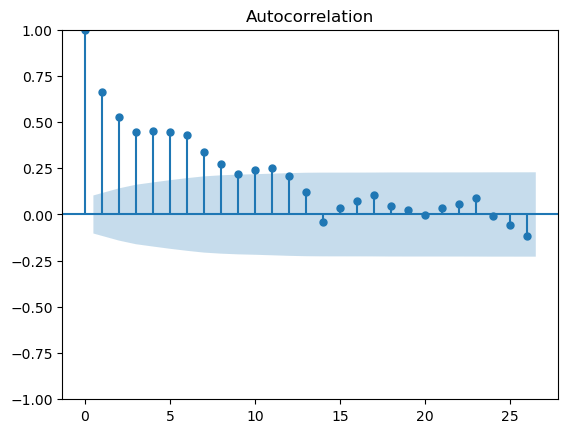

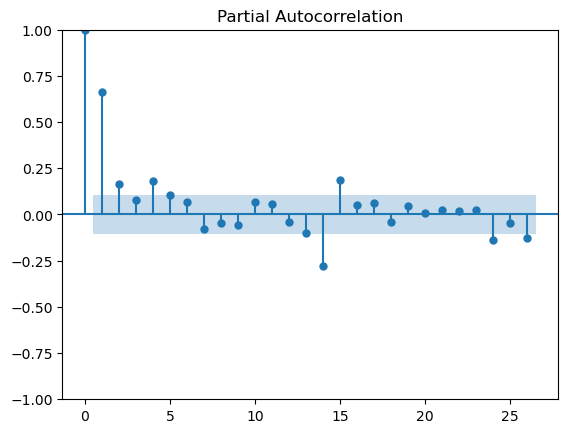

In [7]:
# repeat previous tests for stationarity
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

In [8]:
# visually, data is now less correlated to its lag. Signs series is less stationary

In [9]:
# adf test
adf_test_diff = adfuller(df_train_diff)
print(f'p-value: {adf_test_diff[1]}')

p-value: 0.022059461239126187


In [10]:
# Wow! with that p-value being lower than 0.05, we can reject the null for unit root, confirming stationairty.

In [11]:
# auto-fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                  363
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1096.369
Date:                Sat, 01 Feb 2025   AIC                          -2186.737
Time:                        11:49:52   BIC                          -2175.063
Sample:                             0   HQIC                         -2182.096
                                - 363                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5806      0.050     11.662      0.000       0.483       0.678
ar.L2          0.1687      0.058      2.903      0.004       0.055       0.283
sigma2         0.0001   8.23e-06     16.612      0.0

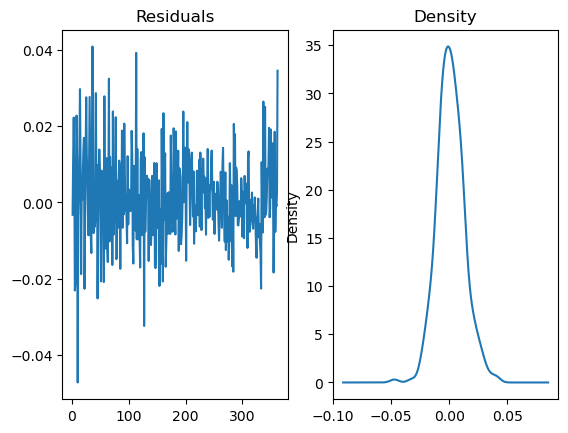

In [12]:
# looks pretty good focusing on ar.1 and ar2 being statistically signicant
# lets plot the distribution of residuals, they should look like white noise

import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()


<AxesSubplot:>

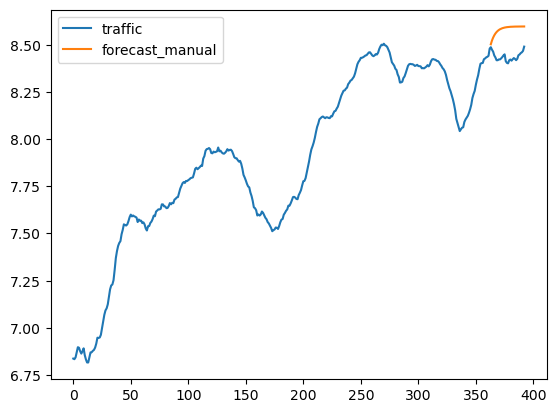

In [13]:
# ready to start modeling

forecast_test = model_fit.forecast(len(df_test))
df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)
df.plot()

In [14]:
# optional: auto-arima models
!pip install pmdarima
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [15]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(5, 1, 0)   Log Likelihood                1107.351
Date:                Sat, 01 Feb 2025   AIC                          -2200.702
Time:                        11:50:04   BIC                          -2173.461
Sample:                             0   HQIC                         -2189.873
                                - 363                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.001      1.471      0.141      -0.000       0.002
ar.L1          0.5236      0.052     10.023      0.000       0.421       0.626
ar.L2          0.0941      0.065      1.446      0.148      -0.033       0.222
ar.L3         -0.0355      0.064     -0.553      0.581      -0.161       0.090
ar.L4          0.1292      0.053      2.442      0.015       0.026       0.233
ar.L5          0.1028      0.049      2.083      0.037       0.006       0.199
sigma2         0.0001    8.6e-06     14.960      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                12.00
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# we now have two possible models; ARIMA (2,1,0) and ARIMA (5,1,0), lets compare their predictions

<AxesSubplot:title={'center':'Traffic Volume Forecast Comparison'}, xlabel='Time Period (Days)', ylabel='Traffic Volume'>

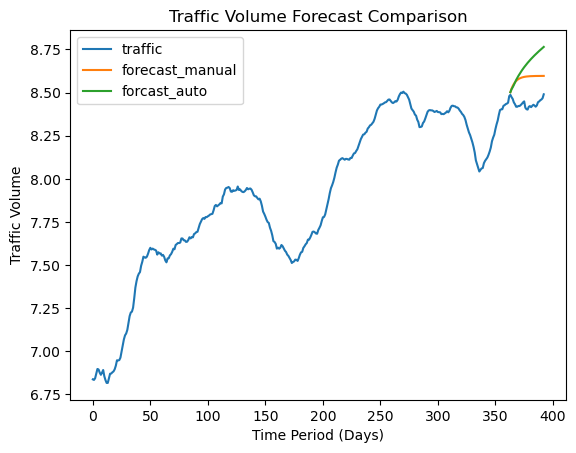

In [19]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df['forcast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot(xlabel='Time Period (Days)', ylabel='Traffic Volume', title='Traffic Volume Forecast Comparison')

In [18]:
# arima (2,1,0) is closer than the auto-arima(5,1,0) to the actual data